Import Statements

In [ ]:
import os
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

Load the helper methods

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,"/content/drive/MyDrive/comp558")
import cnn_helper

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset

In [ ]:
# Dataset: Cifar10 as Place4 (another popular dataset from MIT) is currently unavailble to public
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

Generating Training and testing Dataset. Reference:https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


In [ ]:
class dataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, x, y, batch_size=32, dim=(32, 32), rbg=3, shuffle=True):
      self.batch_size = batch_size 
      self.X = x
      self.y = y
      self.dim = dim
      self.rbg = rbg
      self.shuffle = shuffle
      self.on_epoch_end()

  def __len__(self):
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
      X_inputs, y_output = self.__data_generation(indexes)
      return X_inputs, y_output

  def on_epoch_end(self):
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def generate_mark(self, img):
    # Plain white image
    mark = np.full((32,32,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Pick random 4 point 
      x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
      y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
      thickness = np.random.randint(1, 3)
      # Draw line
      cv2.line(mark,(x1,y1),(x2,y2),(0,0,0),thickness) 
    # Out the marks on the main image
    masked_image = img.copy()
    masked_image[mark==0] = 255
    # return marked image and mark
    return masked_image, mark

  def __data_generation(self, num):
    # empty sets
    Marked_image = np.empty((self.batch_size, 32, 32, self.rbg)) 
    Mark = np.empty((self.batch_size, 32, 32, self.rbg)) 
    Y_b = np.empty((self.batch_size, 32, 32, self.rbg))
    # put the marks on the image in order to generate dataset for the partial convolution
    for i, index in enumerate(num):
      image_copy = self.X[index].copy()
      marked_image, mark = self.generate_mark(image_copy)
      Marked_image[i,] = marked_image/255
      Mark[i,] = mark/255
      Y_b[i] = self.y[index]/255
    return [Marked_image, Mark], Y_b


In [ ]:
training_data = dataGenerator(x_train, x_train)
testing_data = dataGenerator(x_test, x_test)

Helper Function for comparision reference: COMP 551 Comparing data (basically to run compile function)

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [ ]:
from cnn_helper import PConv2D

Main Deep learing Model Refrence: https://github.com/MathiasGruber/PConv-Keras/blob/master/libs/pconv_model.py

In [ ]:
class Model:
  """
  Main Model Class
  to build layers from encoder and decoders
  """
  def build(self, input_size=(32,32,3)):
    # Input Image and Input maels
    in_img = keras.layers.Input(input_size)
    in_region = keras.layers.Input(input_size, name='encoder_input')
    # Partial Convolution Layer
    # encoder
    conv1, mask1, conv2, mask2 = self.encoder(32, in_img, in_region, ['conv1', 'conv2'])
    conv3, mask3, conv4, mask4 = self.encoder(64, conv2, mask2, ['conv3', 'conv4'])
    conv5, mask5, conv6, mask6 = self.encoder(128, conv4, mask4, ['conv5', 'conv6'])
    conv7, mask7, conv8, mask8 = self.encoder(256, conv6, mask6, ['conv7', 'encoder_output'])
    # decoder
    conv9, mask9, conv10, mask10 = self.decocer(256, 128, conv8, mask8, conv7, mask7, ['conv9', 'conv10'])
    conv11, mask11, conv12, mask12 = self.decocer(128, 64, conv10, mask10, conv5, mask5, ['conv11', 'conv12'])
    conv13, mask13, conv14, mask14 = self.decocer(64, 32, conv12, mask12, conv3, mask3, ['conv13', 'conv14'])
    conv15, mask15, conv16, mask16 = self.decocer(32, 3, conv14, mask14, conv1, mask1, ['conv15', 'decoder_output'])
    #final output layer
    fin_layer = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)
    # Return Model structure
    return keras.models.Model(inputs=[in_img, in_region], outputs=[fin_layer])
    
  def encoder(self, filters, in_layer, in_mask, names):
    # Layer 1
    conv_1, mark_1 = PConv2D(32, (3,3), strides=1, padding='same', name=names[0])([in_layer, in_mask])
    conv_1 = keras.activations.relu(conv_1)
    # Layer 2
    conv_2, mark_2 = PConv2D(32, (3,3), strides=2, padding='same', name=names[1])([conv_1, mark_1])
    conv_2 = keras.activations.relu(conv_2)
    return conv_1, mark_1, conv_2, mark_2

  def decocer(self, filter1, filter2, in_img, in_mask, share_img, share_mask, names):
    # recovery from smaller dimention requires collecting and preservinf features
    top_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
    top_mark = keras.layers.UpSampling2D(size=(2,2))(in_mask)
    concat_img = keras.layers.Concatenate(axis=3)([share_img, top_img])
    concat_mark = keras.layers.Concatenate(axis=3)([share_mask, top_mark])
    # Layer 1
    conv_1, mark_1 = PConv2D(filter1, (3,3), padding='same', name=names[0])([concat_img, concat_mark])
    conv_1 = keras.activations.relu(conv_1)
    # Layer 2
    con_2, mask2 = PConv2D(filter2, (3,3), padding='same', name=names[1])([conv_1, mark_1])
    con_2 = keras.activations.relu(con_2)
    return conv_1, mark_1, con_2, mask2

Trainin The Machine Learining Model

In [ ]:
keras.backend.clear_session()
model = Model().build()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
model.fit_generator(training_data, validation_data=testing_data, epochs=4, 
                        steps_per_epoch=len(training_data), 
                        validation_steps=len(training_data),
                        use_multiprocessing=True,)

Epoch 1/4


<ipython-input-138-c27559f4e1cf>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(training_data, validation_data=testing_data, epochs=4,


1562/1562 [==============================] - 1583s 1s/step - loss: 0.0933 - dice_coef: 0.5697 - val_loss: 0.0744 - val_dice_coef: 0.5836
Epoch 2/4
1562/1562 [==============================] - 1557s 996ms/step - loss: 0.0567 - dice_coef: 0.5905 - val_loss: 0.0470 - val_dice_coef: 0.5915
Epoch 3/4
1562/1562 [==============================] - 1559s 997ms/step - loss: 0.0424 - dice_coef: 0.5957 - val_loss: 0.0399 - val_dice_coef: 0.5979
Epoch 4/4
1562/1562 [==============================] - 1560s 998ms/step - loss: 0.0386 - dice_coef: 0.5976 - val_loss: 0.0374 - val_dice_coef: 0.6012


Final Output

1/1 [==============================] - 0s 32ms/step


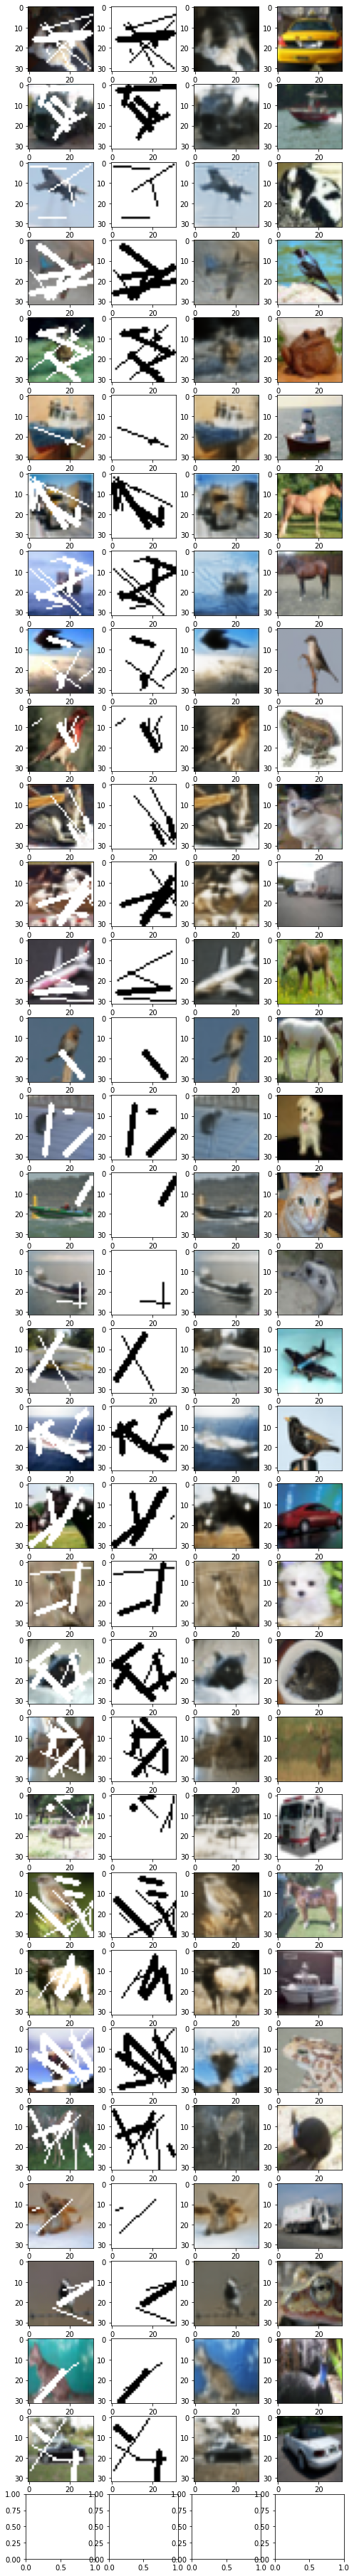

In [ ]:
rows = 33
[x_masked_images, feature_mark], y_labels = testing_data[50]
fig, grid = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))
for index in range(32):
  inputs = [x_masked_images[index].reshape((1,)+x_masked_images[index].shape), feature_mark[index].reshape((1,)+feature_mark[index].shape)]
  impainted_image = model.predict(inputs)
  grid[index][0].imshow(x_masked_images[index])
  grid[index][1].imshow(feature_mark[index])
  grid[index][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  grid[index][3].imshow(y_labels[index])
plt.show()